# Introdução à Ciência de Dados - UFPB
Professor: Yuri Malheiros

Projeto realizado como requisito parcial para conclusão da disciplina de ICD

Alunos: 

    Deivison Rodrigues Jordão
    Lucas Miranda de Aguiar
    Filipe de Medeiros Santos
    

# Análise Exploratória  e Vizualização dos Dados

In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2f' %x)

In [2]:
DataBase = pd.read_csv("healthcare-dataset-stroke-data.csv")
DataBase

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,nan,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.00,1,0,Yes,Private,Urban,83.75,nan,never smoked,0
5106,44873,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0
5107,19723,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0
5108,37544,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0


In [3]:
Stroke_1 = DataBase[DataBase["stroke"] == 1]
Stroke_1

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,nan,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
244,17739,Male,57.00,0,0,Yes,Private,Rural,84.96,36.70,Unknown,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.90,Unknown,1
246,27153,Female,75.00,0,0,Yes,Self-employed,Rural,78.80,29.30,formerly smoked,1
247,34060,Male,71.00,1,0,Yes,Self-employed,Rural,87.80,nan,Unknown,1


In [4]:
Stroke_0 = DataBase[DataBase["stroke"] == 0]
Stroke_0

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
249,30669,Male,3.00,0,0,No,children,Rural,95.12,18.00,Unknown,0
250,30468,Male,58.00,1,0,Yes,Private,Urban,87.96,39.20,never smoked,0
251,16523,Female,8.00,0,0,No,Private,Urban,110.89,17.60,Unknown,0
252,56543,Female,70.00,0,0,Yes,Private,Rural,69.04,35.90,formerly smoked,0
253,46136,Male,14.00,0,0,No,Never_worked,Rural,161.28,19.10,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.00,1,0,Yes,Private,Urban,83.75,nan,never smoked,0
5106,44873,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0
5107,19723,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0
5108,37544,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0


#### Algumas das colunas do dataset trabalhadas em seguida dispõem de dados categóricos, tornando inviável a aplicação de medidas de centralidade e dispersão a essas colunas. Desta forma, será feita uma análise exploratória inicial com base na contagem da ocorrência dos valores categóricos e o uso de gráficos para facilitar a visualização e entendimento dos dados.

## Medidas de centralidade e dispersão relacionadas ao dataset

In [5]:
def medidas(data):
    mean = np.mean(data)
    median = data.median()
    variance = np.var(data)
    std_deviation = np.std(data)
    dict_medidas = {"Média":mean,"Mediana":median,"Variância":variance,"Desvio Padrão":std_deviation}
    return pd.DataFrame(dict_medidas).T

# Idade

## 1. Idade Geral

In [6]:
idade = DataBase[["age"]]
idade

,age
0,67.00
1,61.00
2,80.00
3,49.00
4,79.00
...,...
5105,80.00
5106,81.00
5107,35.00
5108,51.00


In [7]:
medidas(idade)

,age
Média,43.23
Mediana,45.00
Variância,511.23
Desvio Padrão,22.61


### Boxplot

<AxesSubplot:>

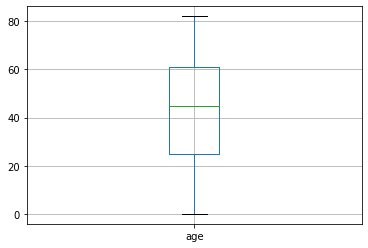

In [8]:
idade.boxplot()

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

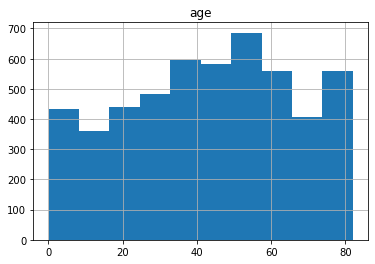

In [9]:
idade.hist()

## 2. Idade dos indivíduos que sofreram ataque cardíaco

In [10]:
idade_1 = Stroke_1[["age"]]
idade_1

,age
0,67.00
1,61.00
2,80.00
3,49.00
4,79.00
...,...
244,57.00
245,14.00
246,75.00
247,71.00


In [11]:
medidas(idade_1)

,age
Média,67.73
Mediana,71.00
Variância,161.34
Desvio Padrão,12.70


### boxplot

<AxesSubplot:>

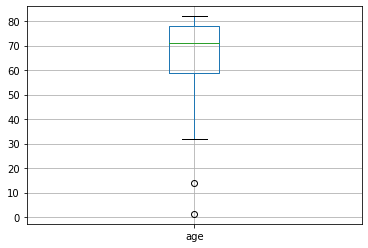

In [12]:
idade_1.boxplot()

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

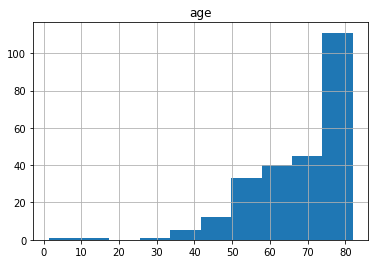

In [13]:
idade_1.hist()

## Idades dos indivíduos que não sofreram ataque cardíaco

In [14]:
idade_0 = Stroke_0[["age"]]
idade_0

,age
249,3.00
250,58.00
251,8.00
252,70.00
253,14.00
...,...
5105,80.00
5106,81.00
5107,35.00
5108,51.00


In [15]:
medidas(idade_0)

,age
Média,41.97
Mediana,43.00
Variância,496.83
Desvio Padrão,22.29


### Boxplot

<AxesSubplot:>

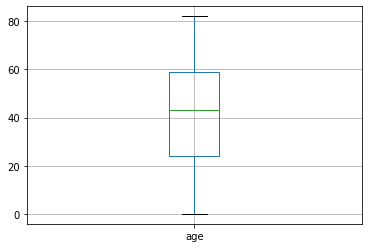

In [16]:
idade_0.boxplot()

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

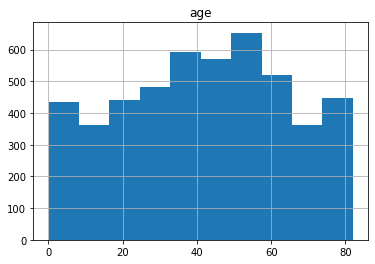

In [17]:
idade_0.hist()

## Nivel de glicose Geral

In [18]:
glicose = DataBase[["avg_glucose_level"]]
glicose

,avg_glucose_level
0,228.69
1,202.21
2,105.92
3,171.23
4,174.12
...,...
5105,83.75
5106,125.20
5107,82.99
5108,166.29


In [19]:
medidas(glicose)

,avg_glucose_level
Média,106.15
Mediana,91.88
Variância,2050.20
Desvio Padrão,45.28


### Boxplot

<AxesSubplot:>

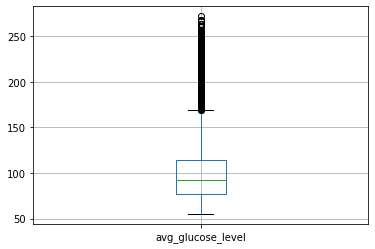

In [20]:
glicose.boxplot()

array([[<AxesSubplot:title={'center':'avg_glucose_level'}>]], dtype=object)

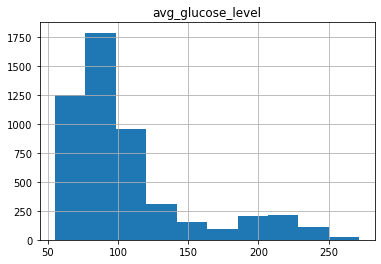

In [21]:
glicose.hist()

## Nivel de glicose dos indivíduos que sofreram ataque cardíaco

In [22]:
glicose_1 = Stroke_1[["avg_glucose_level"]]
glicose_1

,avg_glucose_level
0,228.69
1,202.21
2,105.92
3,171.23
4,174.12
...,...
244,84.96
245,57.93
246,78.80
247,87.80


In [23]:
medidas(glicose_1)

,avg_glucose_level
Média,132.54
Mediana,105.22
Variância,3818.82
Desvio Padrão,61.80


### Boxplot

<AxesSubplot:>

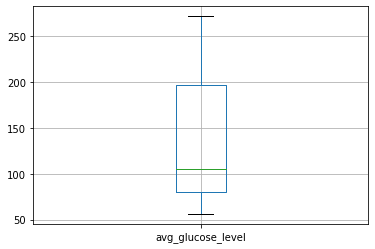

In [24]:
glicose_1.boxplot()

array([[<AxesSubplot:title={'center':'avg_glucose_level'}>]], dtype=object)

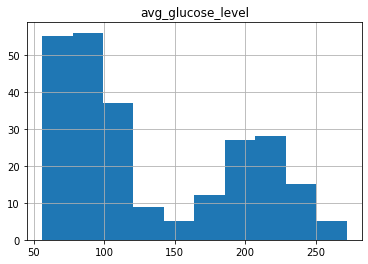

In [25]:
glicose_1.hist()

## Nivel de glicose dos indivíduos que não sofreram ataque cardíaco

In [26]:
glicose_0 = Stroke_0[["avg_glucose_level"]]
glicose_0

,avg_glucose_level
249,95.12
250,87.96
251,110.89
252,69.04
253,161.28
...,...
5105,83.75
5106,125.20
5107,82.99
5108,166.29


In [27]:
media_glicose_0 = np.mean(glicose_0)
mediana_glicose_0 = glicose_0.median()
variancia_glicose_0 = np.var(glicose_0)
desvio_padrao_glicose_0 = np.var(glicose_0)**0.5
dicionario_glicose_0 = {"Média":media_glicose_0,"Mediana":mediana_glicose_0,"Variância":variancia_glicose_0,"Desvio Padrão":desvio_padrao_glicose_0}

In [28]:
medidas_glicose_0 = pd.DataFrame(dicionario_glicose_0).T
medidas_glicose_0

,avg_glucose_level
Média,104.80
Mediana,91.47
Variância,1922.08
Desvio Padrão,43.84


In [29]:
medidas(glicose_0)

,avg_glucose_level
Média,104.80
Mediana,91.47
Variância,1922.08
Desvio Padrão,43.84


### Boxplot

<AxesSubplot:>

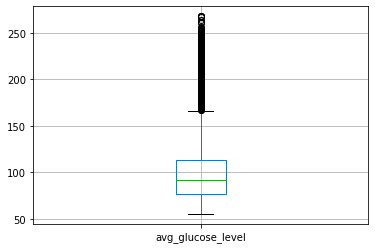

In [30]:
glicose_0.boxplot()

array([[<AxesSubplot:title={'center':'avg_glucose_level'}>]], dtype=object)

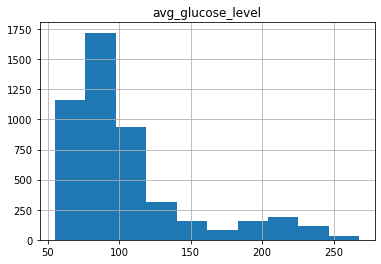

In [31]:
glicose_0.hist()

<AxesSubplot:title={'center':'Indivíduos que sofreram AVC'}, ylabel='Pessoas'>

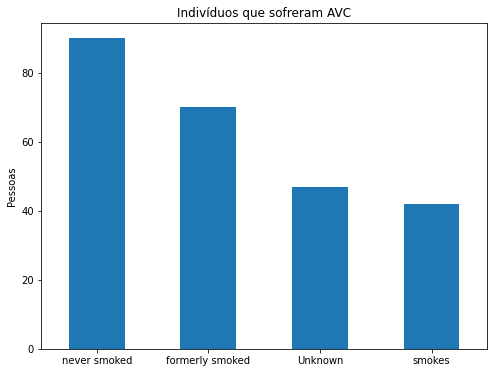

In [319]:
smoke_status = Stroke_1["smoking_status"].value_counts().T
smoke_status.plot.bar(rot=0, ylabel ="Pessoas",title = "Indivíduos que sofreram AVC", figsize=(8,6))

<AxesSubplot:title={'center':'Indivíduos que sofreram AVC'}>

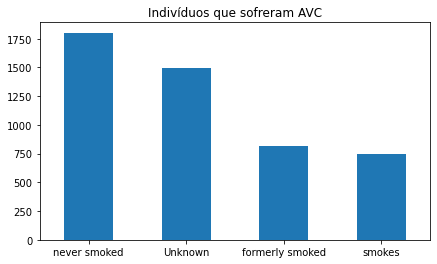

In [321]:
smoke_status = Stroke_0["smoking_status"].value_counts().T
smoke_status.plot.bar(rot=0, ylabel ="",title = "Indivíduos que sofreram AVC", figsize=(7,4))
smoke_status

## Em relação a localidade

### Pessoas que não sofreram ataque cardíaco e sua localidade

In [32]:
residence_0 = DataBase[DataBase.stroke == 0]
residence_0 = residence_0["Residence_type"].value_counts()
residence_0_df = pd.DataFrame(residence_0); residence_0_df

,Residence_type
Urban,2461
Rural,2400


##### Podemos ver que os moradores que não sofreram ataque cardíacos estão bem distribuídas

<AxesSubplot:>

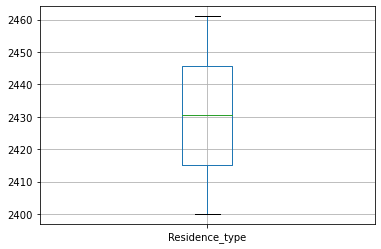

In [34]:
residence_0_df.boxplot()

### Pessoas quie sofreram ataque cardíaco e sua localidade

In [35]:
residence_1 = DataBase[DataBase.stroke == 1]
residence_1 = residence_1["Residence_type"].value_counts()
residence_1_df = pd.DataFrame(residence_1); residence_1_df

,Residence_type
Urban,135
Rural,114


##### Aqui também está bem distribuido

<AxesSubplot:>

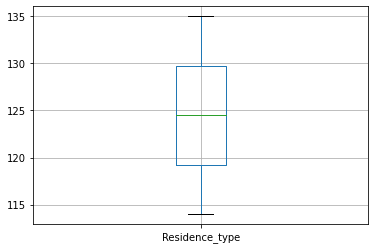

In [37]:
residence_1_df.boxplot()

##### Pode reparar que as pessoas que moram na cidade tem uma porcentagem maior de ter avc

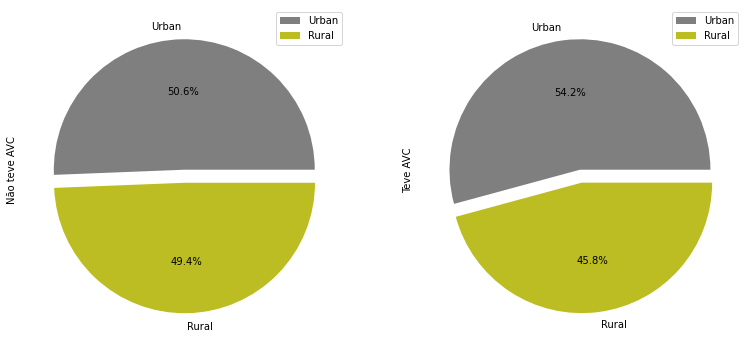

In [297]:
residence = pd.DataFrame({'Não teve AVC': residence_0, 'Teve AVC': residence_1})
residence = residence.plot.pie(subplots= True, figsize= (13,6), explode=(0, 0.1), autopct='%1.1f%%',colors= ['tab:gray','tab:olive'])

## Em relação ao IMC (bmi)

#### IMC de pessoas que não tiveram ataque cardíaco

In [236]:
bmi_0 = DataBase[DataBase.stroke == 0]
bmi_0 = bmi_0["bmi"]
bmi_0 = pd.DataFrame(bmi_0)
bmi_0 = bmi_0.dropna()
bmi_0

,bmi
249,18.00
250,39.20
251,17.60
252,35.90
253,19.10
...,...
5104,18.60
5106,40.00
5107,30.60
5108,25.60


In [40]:
medidas(bmi_0)

,bmi
Média,28.82
Mediana,28.00
Variância,62.53
Desvio Padrão,7.91


##### Aqui temos vários outliers

#### Pessoas que tiveram ataque cardíaco e seu IMC

In [258]:
bmi_1 = DataBase[DataBase.stroke == 1]
bmi_1 = bmi_1["bmi"]
bmi_1 = pd.DataFrame(bmi_1)
bmi_1 = bmi_1.dropna()
bmi_1

,bmi
0,36.60
2,32.50
3,34.40
4,24.00
5,29.00
...,...
243,40.50
244,36.70
245,30.90
246,29.30


In [44]:
medidas(bmi_1)

,bmi
Média,30.47
Mediana,29.70
Variância,39.87
Desvio Padrão,6.31


#### Os dados não tem tanta variação, o que facilita o entendimento

array([[<AxesSubplot:title={'center':'bmi'}>]], dtype=object)

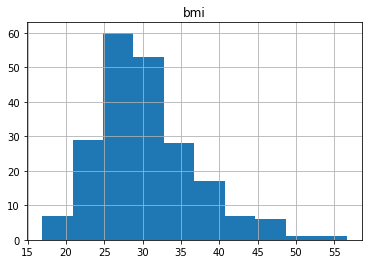

In [46]:
bmi_1.hist()

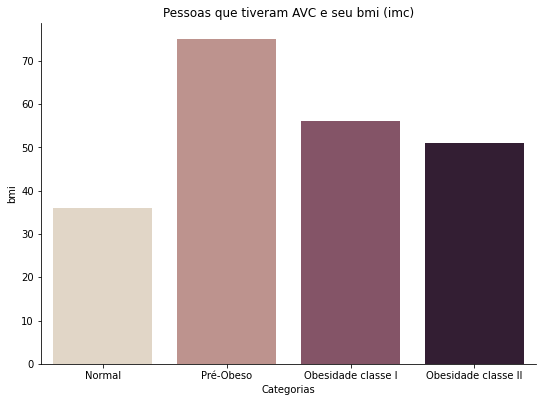

In [293]:
bmi_1 = DataBase[DataBase.stroke == 1]
bmi_1 = bmi_1["bmi"].value_counts()
bmi_1 = bmi_1.dropna()
bmi1 = bmi_1[bmi_1.index < 25].sum()
bmi2 = bmi_1[bmi_1.index < 30].sum() - bmi1
bmi3 = bmi_1[bmi_1.index < 35].sum() -  (bmi2 + bmi1)
bmi4 = bmi_1[bmi_1.index > 34].sum()
df_bmi_1 = pd.DataFrame([{"Normal": bmi1, "Pré-Obeso": bmi2, "Obesidade classe I":bmi3, "Obesidade classe II": bmi4 }])
df_bmi_1 = df_bmi_1.rename({0 :"BMI"}, axis='columns')
df_bmi_1 = sns.catplot(data=df_bmi_1,palette="ch:.25", kind="bar", height=5.27, aspect=11.7/8.27)
df_bmi_1.set(xlabel='Categorias', ylabel='bmi', title='Pessoas que tiveram AVC e seu bmi (imc)')

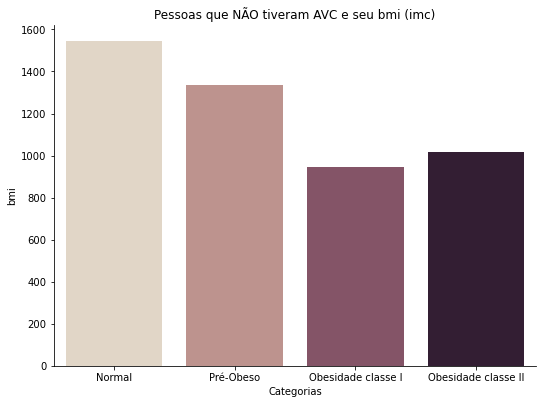

In [290]:
bmi_2 = DataBase[DataBase.stroke == 0]
bmi_2 = bmi_2["bmi"].value_counts()
bmi_2 = bmi_2.dropna()
bmi1 = bmi_2[bmi_2.index < 25].sum()
bmi2 = bmi_2[bmi_2.index < 30].sum() - bmi1
bmi3 = bmi_2[bmi_2.index < 35].sum() -  (bmi2 + bmi1)
bmi4 = bmi_2[bmi_2.index > 34].sum()
df_bmi_2 = pd.DataFrame([{"Normal": bmi1, "Pré-Obeso": bmi2, "Obesidade classe I":bmi3, "Obesidade classe II": bmi4 }])
df_bmi_2 = sns.catplot(data=df_bmi_2,palette="ch:.25", kind="bar", height=5.27, aspect=11.7/8.27)
df_bmi_2.set(xlabel='Categorias', ylabel='bmi', title='Pessoas que NÃO tiveram AVC e seu bmi (imc)')

### Em relação a doenças do coração (heart disease)

In [49]:
heart_disease = DataBase["heart_disease"].value_counts()
heart_disease = pd.DataFrame(heart_disease)
heart_disease = heart_disease.dropna()
heart_disease.rename({0: "No stroke", 1:"stroke"}, axis='index', inplace=True)
heart_disease

,heart_disease
No stroke,4834
stroke,276


In [50]:
heart_disease_0 = DataBase[DataBase.stroke == 0]
heart_disease_0 = heart_disease_0["heart_disease"].value_counts()
heart_disease_1 = DataBase[DataBase.stroke == 1]
heart_disease_1 = heart_disease_1["heart_disease"].value_counts()

heart = pd.DataFrame({"Heart Disease - V": heart_disease_1,
                     "Heart Disease - F": heart_disease_0})
heart = heart.rename({1: "Teve Avc", 0: "Não teve avc"}, axis='index')
heart

,Heart Disease - V,Heart Disease - F
Não teve avc,202,4632
Teve Avc,47,229


##### Podemos ver que existe um número muito alto de pessoas sem problemas do coração e isso acaba prejudicando a análise. Devemos trabalhar com porcentagem.

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

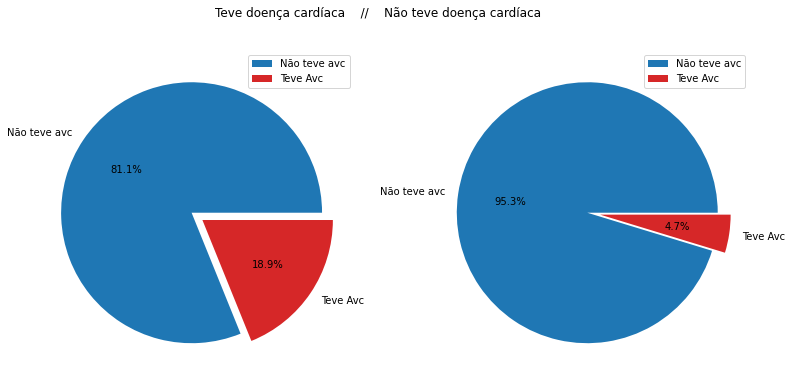

In [213]:
heart.plot.pie(subplots=True, figsize= (13,6), title = 'Teve doença cardíaca    //    Não teve doença cardíaca' , ylabel='',
               explode=(0, 0.1), autopct='%1.1f%%',colors=['tab:blue','tab:red'])

### Em relação à coluna gênero

In [53]:
stroke_1 = DataBase[DataBase["stroke"] == 1]

In [54]:
gender = DataBase["gender"]
gender.head()

0      Male
1    Female
2      Male
3    Female
4    Female
Name: gender, dtype: object

##### Verificando a prevalência de gênero na base de dados

In [55]:
gender = gender.value_counts().to_frame()
gender

,gender
Female,2994
Male,2115
Other,1


##### Incluindo a porcentagem de ocorrência por gênero

In [56]:
gender["gender_perc"] = gender["gender"] / gender["gender"].sum() * 100
gender

,gender,gender_perc
Female,2994,58.59
Male,2115,41.39
Other,1,0.02


In [57]:
gender_1 = stroke_1["gender"]
gender_1.head()

0      Male
1    Female
2      Male
3    Female
4    Female
Name: gender, dtype: object

In [58]:
gender["gender_1"] = gender_1.value_counts()
gender["gender_perc_1"] = gender["gender_1"] / gender["gender_1"].sum() * 100

gender

,gender,gender_perc,gender_1,gender_perc_1
Female,2994,58.59,141.00,56.63
Male,2115,41.39,108.00,43.37
Other,1,0.02,nan,nan


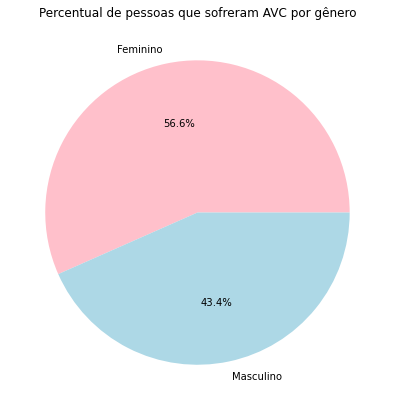

In [79]:
gender["gender_perc_1"].dropna().plot.pie(title="Percentual de pessoas que sofreram AVC por gênero",
                                 ylabel='', colors=['pink', 'lightblue'], autopct='%1.1f%%',
                                 labels=["Feminino", "Masculino", ""], figsize=(13,7));

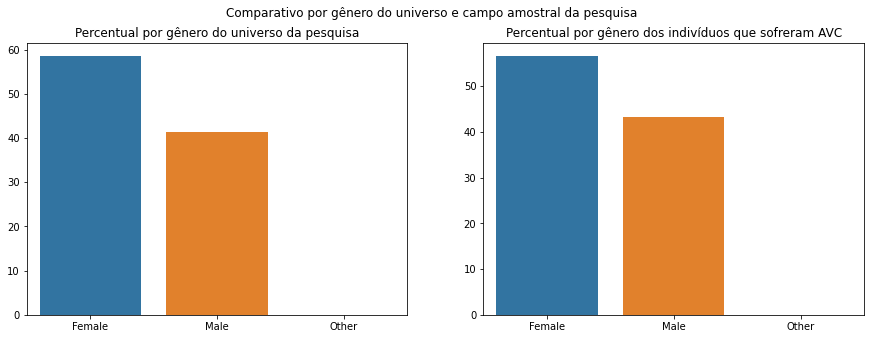

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Comparativo por gênero do universo e campo amostral da pesquisa')

sns.barplot(ax=axes[0], x=gender.index, y='gender_perc', data=gender)
axes[0].set_title('Percentual por gênero do universo da pesquisa')
axes[0].set_ylabel('')

sns.barplot(ax=axes[1], x=gender.index, y='gender_perc_1', data=gender)
axes[1].set_title('Percentual por gênero dos indivíduos que sofreram AVC')
axes[1].set_ylabel('');

In [61]:
# Incluindo uma coluna com relação por gênero dos indivíduos que não tiveram AVC

gender['gender_0'] = gender['gender'] - gender['gender_1']
gender

,gender,gender_perc,gender_1,gender_perc_1,gender_0
Female,2994,58.59,141.00,56.63,2853.00
Male,2115,41.39,108.00,43.37,2007.00
Other,1,0.02,nan,nan,nan


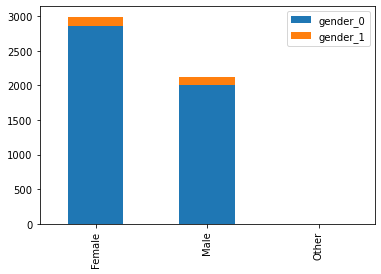

In [62]:
gender[['gender_0', 'gender_1']].plot.bar(stacked=True);

### Em relação ao estado civil

In [63]:
married = DataBase["ever_married"]
married.head()

0    Yes
1    Yes
2    Yes
3    Yes
4    Yes
Name: ever_married, dtype: object

##### Verificando a prevalência de pessoas que já foram casadas na base de dados

In [64]:
married = married.value_counts().to_frame()
married

,ever_married
Yes,3353
No,1757


##### Incluindo a porcentagem de ocorrência

In [65]:
married["married_perc"] = married["ever_married"] / married["ever_married"].sum() * 100
married

,ever_married,married_perc
Yes,3353,65.62
No,1757,34.38


In [66]:
married_1 = stroke_1["ever_married"]
married_1.head()

0    Yes
1    Yes
2    Yes
3    Yes
4    Yes
Name: ever_married, dtype: object

#####  Verificando a prevalência de pessoas que já foram casadas nas entradas em que houveram a ocorrência de AVC e Incluindo a porcentagem no dataframe

In [67]:
married["ever_married_1"] = married_1.value_counts()
married["married_perc_1"] = married["ever_married_1"] / married["ever_married_1"].sum() * 100

married

,ever_married,married_perc,ever_married_1,married_perc_1
Yes,3353,65.62,220,88.35
No,1757,34.38,29,11.65


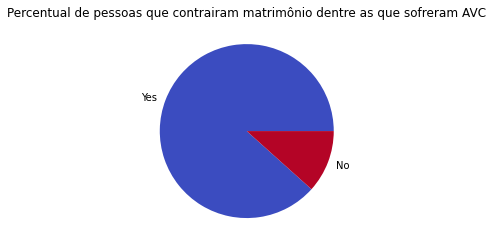

In [68]:
married["married_perc_1"].plot.pie(title="Percentual de pessoas que contrairam matrimônio dentre as que sofreram AVC", ylabel='', colormap="coolwarm");

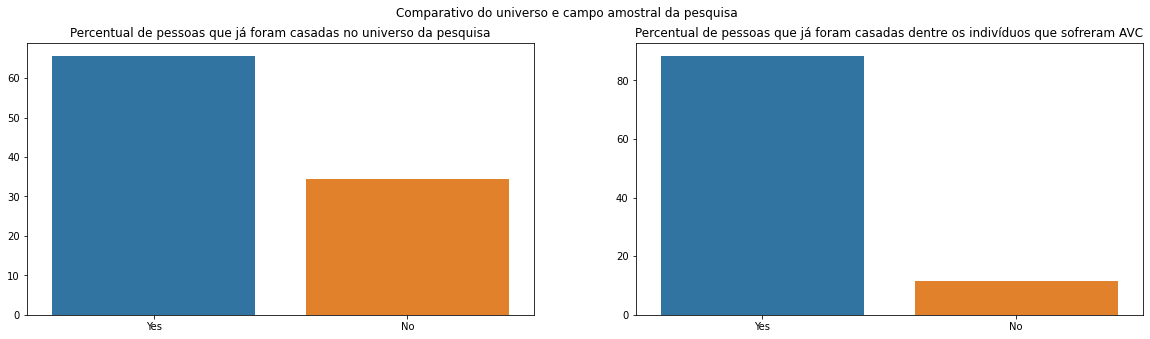

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Comparativo do universo e campo amostral da pesquisa')

sns.barplot(ax=axes[0], x=married.index, y='married_perc', data=married)
axes[0].set_title('Percentual de pessoas que já foram casadas no universo da pesquisa')
axes[0].set_ylabel('')

sns.barplot(ax=axes[1], x=married.index, y='married_perc_1', data=married)
axes[1].set_title('Percentual de pessoas que já foram casadas dentre os indivíduos que sofreram AVC')
axes[1].set_ylabel('');

### Tipo de trabalho 

In [70]:
work = DataBase["work_type"]
work.head()

0          Private
1    Self-employed
2          Private
3          Private
4    Self-employed
Name: work_type, dtype: object

In [71]:
work = work.value_counts().to_frame()
work

,work_type
Private,2925
Self-employed,819
children,687
Govt_job,657
Never_worked,22


###### Incluindo a porcentagem de ocorrência por tipo de trabalho

In [72]:
work["work_perc"] = work["work_type"] / work["work_type"].sum() * 100
work

,work_type,work_perc
Private,2925,57.24
Self-employed,819,16.03
children,687,13.44
Govt_job,657,12.86
Never_worked,22,0.43


In [73]:
work_1 = stroke_1["work_type"]
work_1.head()

0          Private
1    Self-employed
2          Private
3          Private
4    Self-employed
Name: work_type, dtype: object

##### Verificando a prevalência pelo tipo de trabalho das entradas em que houveram a ocorrência de AVC e Incluindo a porcentagem no dataframe

In [74]:
work["work_type_1"] = work_1.value_counts()
work["work_perc_1"] = work["work_type_1"] / work["work_type_1"].sum() * 100

work

,work_type,work_perc,work_type_1,work_perc_1
Private,2925,57.24,149.00,59.84
Self-employed,819,16.03,65.00,26.10
children,687,13.44,2.00,0.80
Govt_job,657,12.86,33.00,13.25
Never_worked,22,0.43,nan,nan


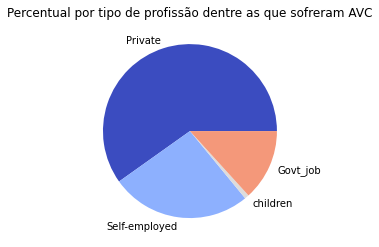

In [75]:
work["work_perc_1"].plot.pie(title="Percentual por tipo de profissão dentre as que sofreram AVC", ylabel='', colormap="coolwarm");

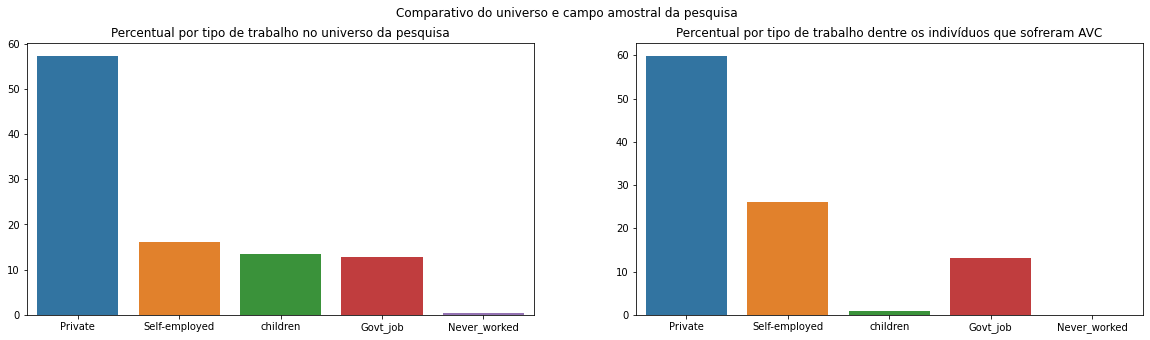

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Comparativo do universo e campo amostral da pesquisa')

sns.barplot(ax=axes[0], x=work.index, y='work_perc', data=work)
axes[0].set_title('Percentual por tipo de trabalho no universo da pesquisa')
axes[0].set_ylabel('')

sns.barplot(ax=axes[1], x=work.index, y='work_perc_1', data=work)
axes[1].set_title('Percentual por tipo de trabalho dentre os indivíduos que sofreram AVC')
axes[1].set_ylabel('');